## Image classification with Vision Transformer



In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]#để tối ưu tốc độ tính toán

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

### Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


### Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs_train = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]#Số lượng neuron của các tầng trong transformer Encoder
transformer_layers = 8
mlp_head_units = [2048, 1024]#kích thước của dense layers cuồi cùng của lớp classifier


### Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),#lật ngang
        layers.RandomRotation(factor=0.02),#xoay
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),#phóng to
    ],
    name="data_augmentation",

)
#Compute the mean and the variabce of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

### Implement multilayer perceptron(MLP)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [6]:
#Chia ảnh thành các patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = ops.shape(images)[0]#Lấy số lượng ảnh trong batch
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        #Tạo patch từ ảnh
        patches = keras.ops.image.extract_patches(
            images=images,
            size=self.patch_size
        )
        #Đổi patch thành tensor
        patches = ops.reshape(patches, (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels),
                              )
        return patches
        #Lưu kích thước patch khi lưu/trích xuất mô hình
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return super().get_config()


#### Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


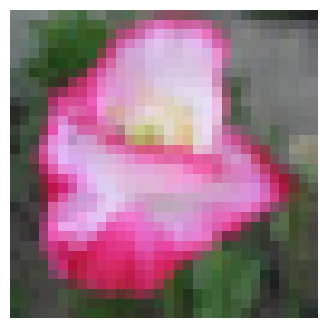

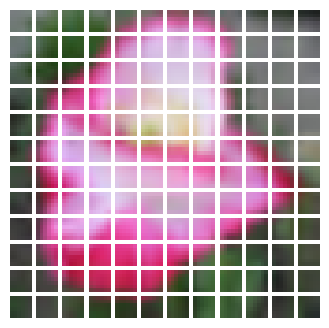

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
#Ảnh từ CIFAR-100 có size 32x32, cần phải resize lên 72x72
resized_image = ops.image.resize(
    ops.convert_to_tensor([image], dtype="float32"), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

### Implement the patch encoding layer
Thực hiện mã hóa các patches bằng cách:
1. Dựng vector đặc trưng từ từng patch thông qua một lớp Dense
2. Thêm thông tin về vị trí của mỗi patch bằng position_embedding
(Mô hình ViT trong có cấu trúc tuần tự như CNN, nên cần phải thêm thông tin vị trí patches để nó hiểu được thứ tự của chúng)

In [8]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        # khởi tạo lớp để biến đổi ma trận ảnh thành vector
        self.projection = layers.Dense(units=projection_dim)#kích thước vector đặc trưng sau khi mã hóa
        #khởi tạo lớp mã hóa vị trí cho từng patch( mỗi vị trí patch được ánh xạ thành một vector có kích thước projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    #Xử lý dữ liệu đầu vào
    def call(self, patch):
      #Tạo vị trí cho từng patch và thêm một chiều patch để có dạng [1, num_patches]
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded
    #Lưu lớp cấu hình
    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


### Build the ViT model

In [9]:
#Xây dựng mô hình Vision Transformer(ViT)
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Tạo patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Xây dựng Transformer Encoder
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer: với 4 attention song song
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1(Residual Connection): giúp gradient không bị mất khi backward
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP: gồm 2 tầng Dense + GELU activation giúp biến đổi dữ liệu phi tuyến
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP: với 2 lớp Dense(2048->1024)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.0309 - loss: 4.9124 - top-5-accuracy: 0.1135 - val_accuracy: 0.1152 - val_loss: 3.9195 - val_top-5-accuracy: 0.3070
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.0877 - loss: 3.9999 - top-5-accuracy: 0.2733 - val_accuracy: 0.1554 - val_loss: 3.5829 - val_top-5-accuracy: 0.4088
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.1299 - loss: 3.7171 - top-5-accuracy: 0.3598 - val_accuracy: 0.2066 - val_loss: 3.3266 - val_top-5-accuracy: 0.4760
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.1614 - loss: 3.5202 - top-5-accuracy: 0.4213 - val_accuracy: 0.2330 - val_loss: 3.1290 - val_top-5-accuracy: 0.5328
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.1859 - loss: 3.3657 - top-5-accuracy: 0.4611 - val_accuracy: 0.2604 - val_loss: 2.9917 - val_top-5-accuracy: 0.5564
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.2102 - loss:

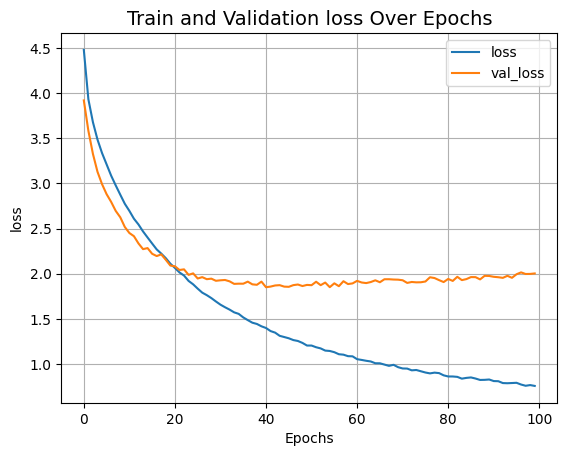

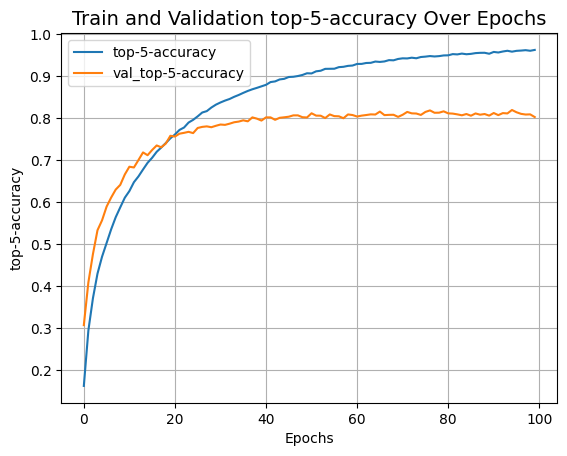

In [10]:

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs_train,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()ư


plot_history("loss")
plot_history("top-5-accuracy")
